# Software project 1
### by RISS Ryan

#### Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import cross_val_score
import numpy as np

## Step 1 : First data anaysis

In [3]:
aoeData = pd.read_csv('data/aoe_data.csv')

In [4]:
print(aoeData.shape[0])
print(aoeData.columns)
aoeData = aoeData.dropna()
print(aoeData.shape[0])

224599
Index(['Unnamed: 0', 'match_id', 'map', 'map_size', 'duration', 'dataset',
       'difficulty', 'elo', 'p1_civ', 'p2_civ', 'p1_xpos', 'p2_xpos',
       'p1_ypos', 'p2_ypos', 'winner'],
      dtype='object')
214003


We will only using map, duration, elo, p1_civ, p2_civ, p1_xpos, p2_xpos, p1_ypos, p2_ypos and winner.
Roughy 10k entries have na values.

Lets see the distribution of the picked features

Min elo: 682.0
Max elo: 2523.0
Mean elo: 1128.8441820909052


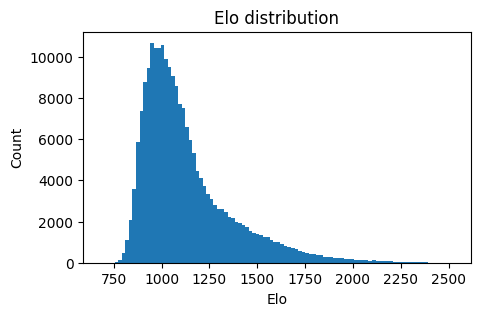

Min duration: 0
Max duration: 23249
Mean duration: 2293.2049831077134


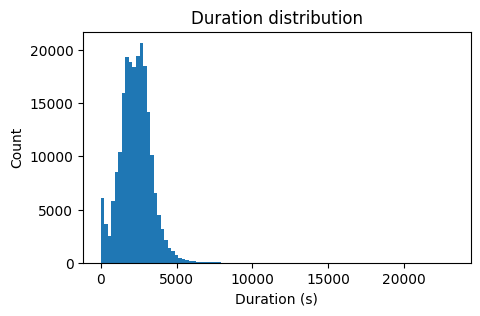

In [5]:
eloData = aoeData['elo']

minElo = eloData.min()
maxElo = eloData.max()
meanElo = eloData.mean()

print(f"Min elo: {minElo}")
print(f"Max elo: {maxElo}")
print(f"Mean elo: {meanElo}")


fig, ax = plt.subplots(figsize=(5, 3))

ax.hist(eloData, bins=100)

ax.set_title('Elo distribution')
ax.set_xlabel('Elo')
ax.set_ylabel('Count')

plt.show()

durationData = aoeData['duration']

minDur = durationData.min()
maxDur = durationData.max()
meanDur = durationData.mean()

print(f"Min duration: {minDur}")
print(f"Max duration: {maxDur}")
print(f"Mean duration: {meanDur}")

fig, ax = plt.subplots(figsize=(5, 3))

ax.hist(durationData, bins=100)

ax.set_title('Duration distribution')
ax.set_xlabel('Duration (s)')
ax.set_ylabel('Count')

plt.show()



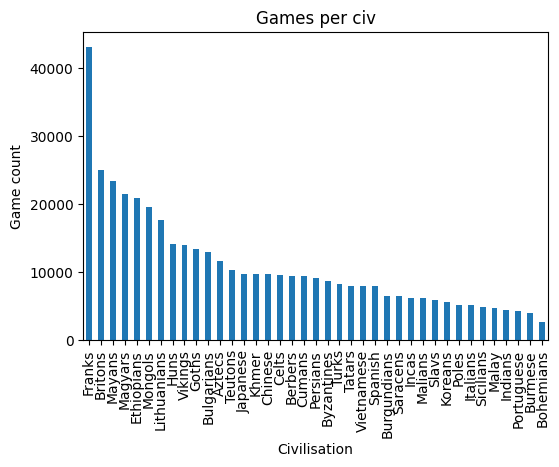

In [5]:

civData = pd.concat([aoeData['p1_civ'], aoeData['p2_civ']])

civsCount = civData.value_counts()

civsCount = civsCount.sort_values(ascending=False)

plt.figure(figsize=(6, 4))
civsCount.plot(kind='bar')

plt.xlabel('Civilisation')
plt.ylabel('Game count')
plt.title('Games per civ')

plt.show()


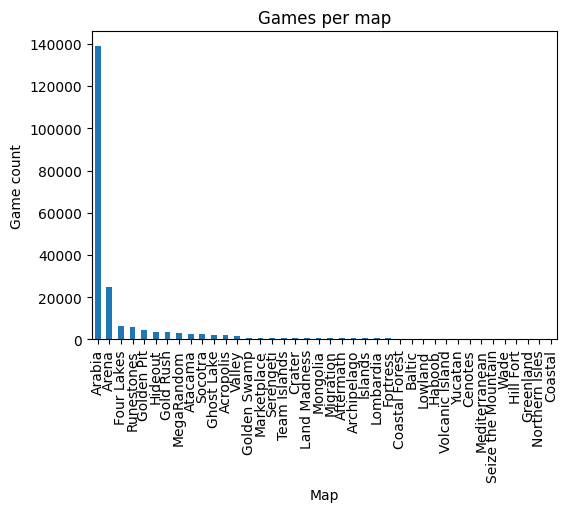

In [6]:
mapData = aoeData['map']

mapsCount = mapData.value_counts()

mapsCount = mapsCount.sort_values(ascending=False)

plt.figure(figsize=(6, 4))
mapsCount.plot(kind='bar')

plt.xlabel('Map')
plt.ylabel('Game count')
plt.title('Games per map')

plt.show()


c:\Users\ryan1\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


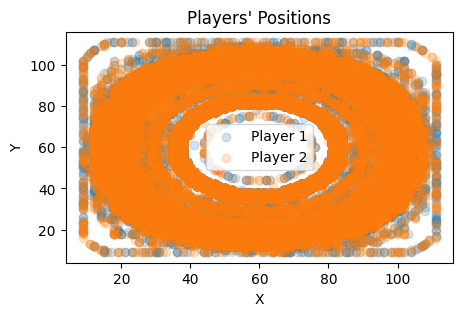

In [7]:
plt.figure(figsize=(5, 3))
plt.scatter(aoeData['p1_xpos'], aoeData['p1_ypos'], label='Player 1', alpha=0.2)

plt.scatter(aoeData['p2_xpos'], aoeData['p2_ypos'], label='Player 2', alpha=0.2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Players\' Positions')
plt.legend() 

plt.show()


Mean mean winner: 0.5096604023493975


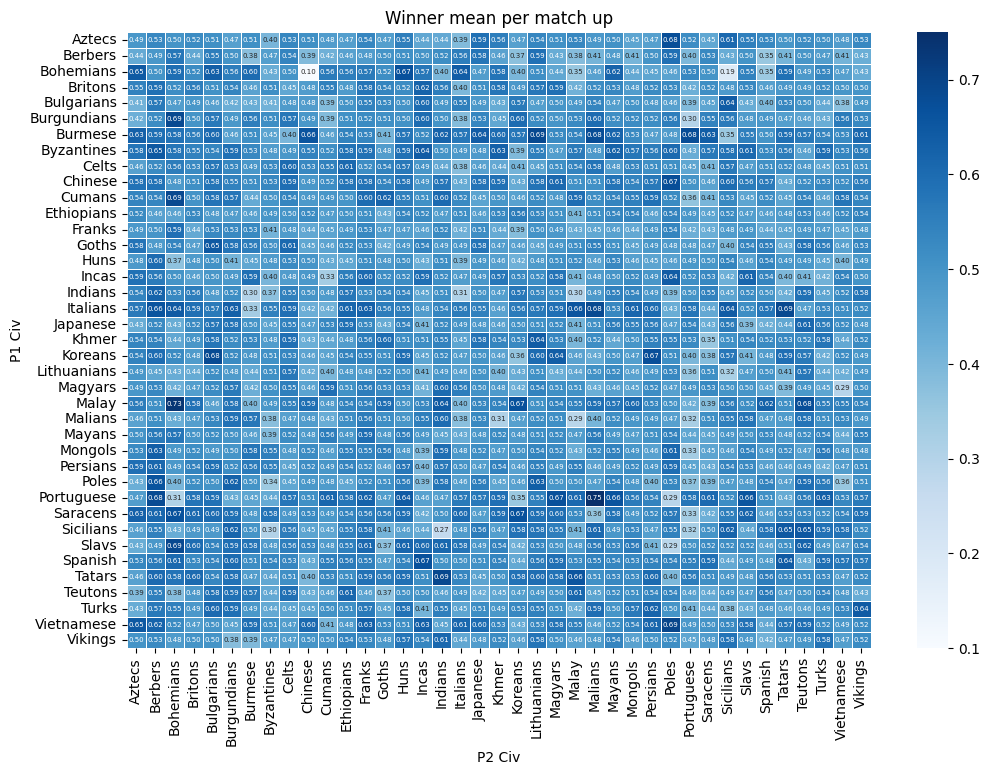

In [8]:
table = pd.pivot_table(aoeData, values='winner', index=['p1_civ', 'p2_civ'], aggfunc='mean')

table = table.reset_index()

table = table.rename(columns={'winner': 'mean_winner'})

hmData = table.pivot('p1_civ', 'p2_civ', 'mean_winner')

meanMeanWinner = table['mean_winner'].mean()

print(f"Mean mean winner: {meanMeanWinner}")

plt.figure(figsize=(12, 8))
sns.heatmap(hmData, annot=True, cmap='Blues', fmt=".2f", linewidths=.5, annot_kws={"size": 5, "rotation": 0})
plt.title('Winner mean per match up')
plt.xlabel('P2 Civ')
plt.ylabel('P1 Civ')
plt.show()

Some map are overpresented (Arabia) and also some civ (Franks). Additionally some match ups are unbalanced.

## Step 2 : Using models

Extracting the features

In [6]:
features = aoeData[['duration', 'map', 'elo', 'p1_civ', 'p2_civ', 'p1_xpos', 'p2_xpos', 'p1_ypos', 'p2_ypos', 'winner']]

target = features['winner']
features = features.drop('winner', axis=1)

Normalization/Standardization

In [7]:
featuresScaled = features.copy()

standardScaler = StandardScaler()
minMaxScaler = MinMaxScaler()

# Duration standardized (outlier values)
featuresScaled['duration'] = standardScaler.fit_transform(features[['duration']])

# Min-Max scaling for the rest (gaussian or uniform distrib)
columsToMinMax = ['elo', 'p1_xpos', 'p2_xpos', 'p1_ypos', 'p2_ypos']
featuresScaled[columsToMinMax] = minMaxScaler.fit_transform(features[columsToMinMax])

# One-hot encode civilizations
featuresScaled = pd.get_dummies(featuresScaled, columns=['p1_civ', 'p2_civ'], prefix=['p1_civ', 'p2_civ'])
featuresScaled = pd.get_dummies(featuresScaled, columns=['map'], prefix=['map'])

# Séparation des données
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    featuresScaled,
    target,
    test_size=0.2,
    random_state=1,
    stratify=target
)

# Imprimer les valeurs de la première ligne après la normalisation
print(X_train_scaled.iloc[0, :])


duration              -2.230018
elo                    0.248778
p1_xpos                0.509804
p2_xpos                0.274510
p1_ypos                0.901961
                         ...   
map_Team Islands       0.000000
map_Valley             0.000000
map_Volcanic Island    0.000000
map_Wade               0.000000
map_Yucatan            0.000000
Name: 16539, Length: 124, dtype: float64


Without Cross Validation



Epoch 1/10


17121/17121 [==============================] - 32s 2ms/step - loss: 0.6911 - accuracy: 0.5245
Epoch 2/10
17121/17121 [==============================] - 29s 2ms/step - loss: 0.6879 - accuracy: 0.5408
Epoch 3/10
17121/17121 [==============================] - 32s 2ms/step - loss: 0.6856 - accuracy: 0.5485
Epoch 4/10
17121/17121 [==============================] - 24s 1ms/step - loss: 0.6832 - accuracy: 0.5553
Epoch 5/10
17121/17121 [==============================] - 25s 1ms/step - loss: 0.6811 - accuracy: 0.5589
Epoch 6/10
17121/17121 [==============================] - 22s 1ms/step - loss: 0.6791 - accuracy: 0.5641
Epoch 7/10
17121/17121 [==============================] - 30s 2ms/step - loss: 0.6768 - accuracy: 0.5679
Epoch 8/10
17121/17121 [==============================] - 38s 2ms/step - loss: 0.6749 - accuracy: 0.5710
Epoch 9/10
17121/17121 [==============================] - 32s 2ms/step - loss: 0.6730 - accuracy: 0.5745
Epoch 10/10
1338/1338 [============================

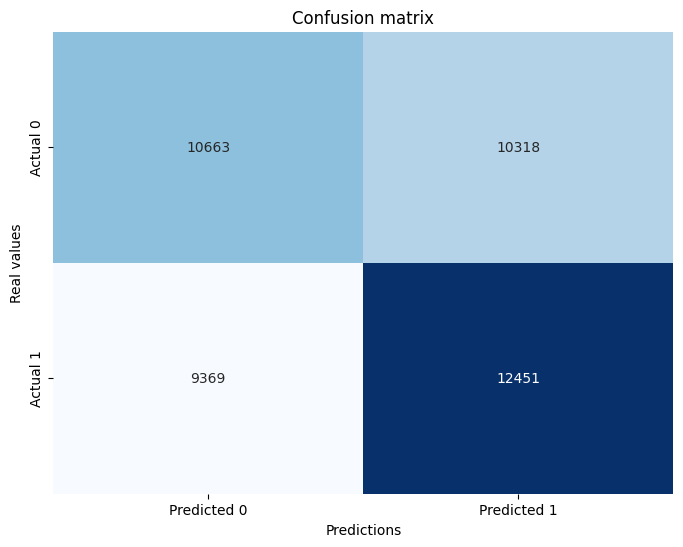

In [8]:
# Create the model
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the mode
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=10, validation_split=0.0)

# Make predictions
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

conf_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion matrix')
plt.xlabel('Predictions')
plt.ylabel('Real values')
plt.show()


With Cross Validation

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Selecting features and target variable
features = aoeData[['duration', 'map', 'elo', 'p1_civ', 'p2_civ', 'p1_xpos', 'p2_xpos', 'p1_ypos', 'p2_ypos', 'winner']]
target = features['winner']
features = features.drop('winner', axis=1)

# Feature scaling and one-hot encoding
featuresScaled = features.copy()
standardScaler = StandardScaler()
minMaxScaler = MinMaxScaler()

featuresScaled['duration'] = standardScaler.fit_transform(features[['duration']])
columnsToMinMax = ['elo', 'p1_xpos', 'p2_xpos', 'p1_ypos', 'p2_ypos']
featuresScaled[columnsToMinMax] = minMaxScaler.fit_transform(features[columnsToMinMax])
featuresScaled = pd.get_dummies(featuresScaled, columns=['p1_civ', 'p2_civ'], prefix=['p1_civ', 'p2_civ'])
featuresScaled = pd.get_dummies(featuresScaled, columns=['map'], prefix=['map'])

# Splitting the data
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    featuresScaled,
    target,
    test_size=0.2,
    random_state=1,
    stratify=target
)

# Creating the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Cross validation
num_folds = 6
kf = KFold(n_splits=num_folds, shuffle=True, random_state=1)

accuracy_scores = []

# Iterate over the folds
for train_index, val_index in kf.split(X_train_scaled):
    # Split the data into training and validation sets for this fold
    X_fold_train, X_fold_val = X_train_scaled.iloc[train_index], X_train_scaled.iloc[val_index]
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model
    model.fit(X_fold_train, y_fold_train, epochs=1, batch_size=5, validation_split=0.2)

    # Make predictions
    y_pred_proba = model.predict(X_fold_val)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate accuracy
    accuracy = accuracy_score(y_fold_val, y_pred)
    accuracy_scores.append(accuracy)

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", accuracy_scores)

# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(accuracy_scores)
print("Mean accuracy:", mean_accuracy)


892/892 [==============================] - 1s 1ms/step
Accuracy scores for each fold: [0.532067007780192, 0.5372888483913927, 0.5406532557650522, 0.5519730847410107, 0.5506956856972628, 0.5569340763326674]
Mean accuracy: 0.544935326451263
